# Introduction

In this lesson we'll discuss a method for avoid overfitting that is commonly referred to a the _train/test split_. This is a type of cross-validation in that we split the dataset into two subsets:
* a subset to train our model on, and
* a subset to test our model's predictions on

This serves two useful purposes:
* We prevent overfitting by not using all the data, and
* We have some remaining data to evaluate our model.

While it may seem like a relatively simple idea, there are some caveats to putting it into practice. For example, if you are not careful it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed 80% of data from the UK and 20% from Ireland and is sorted by country. If we split our data into 80% training data and 20% testing data we might inadvertantly select all the UK data to train and all the non-UK data to test. In this case we've still overfit on our data set despite our train-test split because we did not sufficiently randomise the data.

In a situation like this we can randomise our data sorting beforehand, or we can use a stratified split to ensure equal distribution of the underlying sets.

A particularly popular approach, and one that is most useful if data is relatively scarce, is to use _k-fold cross validation_, which is cross validation applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We then iterate this for each of the possible $k$ subsets. Then we report statistics that are combined from each subset. Note that we should still have a separate test dataset which is untouched for a final validation, but here we rather focus on the mechanics of the cross validation.

# Demo
Let's explore test-training split with some sample datasets.

In [3]:
% matplotlib inline
from __future__ import print_function
from matplotlib import pyplot as plt
# Make the plots bigger
#plt.rcParams['figure.figsize'] = 10, 10

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.cross_validation import train_test_split

# Load the diabetes dataset
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data, columns=columns)
y = diabetes.target
# Take a look at the data again
df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


## Cross validation
Scikit-learn has a nice function to split a dataset for testing and training called `train_test_split`. The `test_size` keyword argument indicates the proportion of the data that should be held over for testing.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.4)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(265, 10) (265,)
(177, 10) (177,)


Now we fit a model on the training data and test on the testing data.

R**2 score method 1: 0.486011186194
R**2 score method 2: 0.486011186194


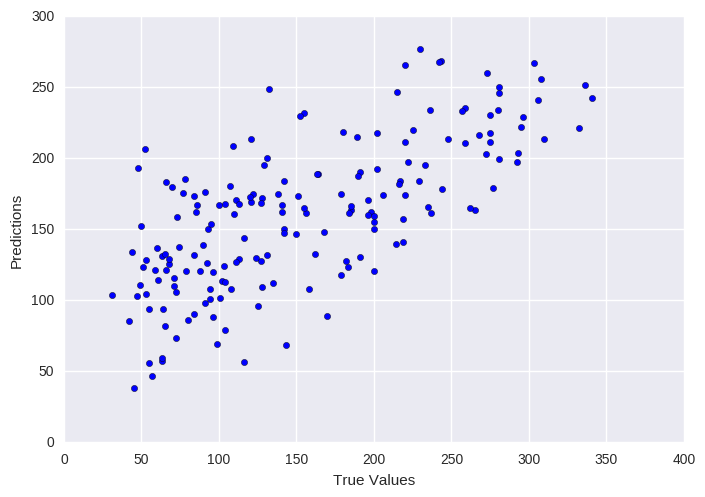

In [16]:
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# since this is a multivariate linear regression we can't readily plot the data and the line of best fit as we have
# done before for single predictor fits, however we can plot the predictions against the true values
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# this returns the coefficient of determination of the prediction (R**2)
print("R**2 score method 1:", model.score(X_test, y_test))  

# alternatively we can use
from sklearn import metrics
r2 = metrics.r2_score(y_test, predictions)
print("R**2 score method 2:", r2)

plt.show()

In [17]:
# the coef_ element allows us to access the coefficients of the linear model (plus the intercept from intercept_)
print(model.coef_)
print("--")
print(df.columns)
print("--")
print(model.intercept_)

[ -22.7211478  -256.80976202  452.96256682  344.51202579 -453.1517647
  339.76021134 -178.15358788  -62.64735116  632.20548521  122.31892821]
--
Index([u'age', u'sex', u'bmi', u'map', u'tc', u'ldl', u'hdl', u'tch', u'ltg',
       u'glu'],
      dtype='object')
--
154.720689528


Note that we could always split the data up manually. Here's an example for [this dataset](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) of a manual splitting.


## K fold cross validation
Now let's try out k-fold cross-validation. Again scikit-learn provides useful functions to do the heavy lifting. The function `cross_val_predict` returns the predicted values for each data point when it's in the testing slice.

Cross-validated scores: [ 0.55614411  0.23056092  0.35357777  0.62190498  0.26587602  0.61819338
  0.41815916  0.43515232  0.43436983  0.68568514]
Mean of the cross-validation scores: 0.461962361958
Cross-Predicted r2: 0.494251180619


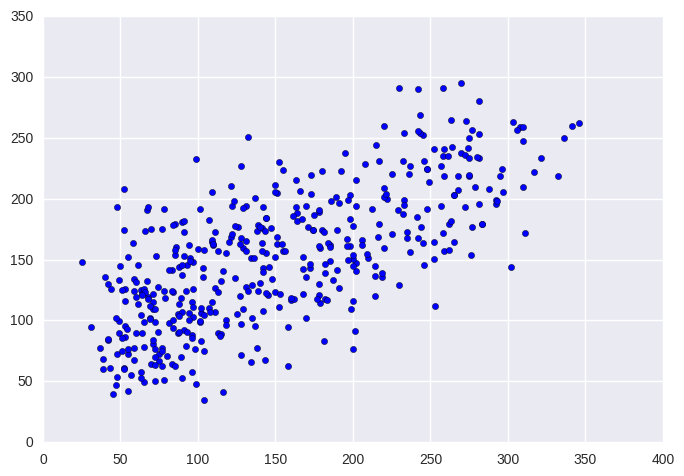

In [18]:
from sklearn.cross_validation import cross_val_score, cross_val_predict

# Perform 10-fold cross validation
scores = cross_val_score(model, df, y, cv=10, scoring="r2")
print("Cross-validated scores:", scores)
print("Mean of the cross-validation scores:",np.mean(scores))
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=10)

# plot
plt.scatter(y, predictions)
r2 = metrics.r2_score(y, predictions)
print("Cross-Predicted r2:", r2)
plt.show()

In [32]:
# specifically, the MSE will be the mean average of the calculated MSE of each fold
# hence the r2 does not come out as the mean average of each of the folds (you can test for MSE if you like)
# presumably because the SStot would be expected to vary depending on the sample, but it will be close
# unless the folds were very poorly stratified (check the source code for the exact implementation)

# Guided Practice

Use what you've learned to train and test models on the Boston housing data set. If you need a few hints take a look at [this example](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html) but try your best to make it happen first. Complete the following tasks:
* Fit a linear model to the Boston Housing data using all the available variables. Perform test training splits of 50:50, 70:30, and 90:10, comparing the scores on test data.
* For the same setup, perform a $k$-fold cross validation with $k=5$ slices (with cross-validated predictions)

In [44]:
from sklearn import datasets
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd

lr = linear_model.LinearRegression()
boston = datasets.load_boston()
y = boston.target

columns = "CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT".split()
df = pd.DataFrame(boston.data, columns=columns)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
print("R**2 score method 2:", r2)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.5)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
print("R**2 score method 2:", r2)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.7)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
print("R**2 score method 2:", r2)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.9)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
print("R**2 score method 2:", r2)

print("\nCross validation ----------------")
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2,random_state=1503)
model = lr.fit(X_train, y_train)
predictions1 = model.predict(X_train)
r2 = metrics.r2_score(y_train, predictions1)
print("R**2 score method 2:", r2)

scores = cross_val_score(model, X_train, y_train, cv=10, scoring="r2")
print("Cross-validated scores:", scores)
print("Mean of the cross-validation scores:",np.mean(scores))
# Make cross validated predictions
predictions2 = model.predict(X_test)
r2 = metrics.r2_score(y_test, predictions2)
print("Cross-Predicted r2:", r2)


R**2 score method 2: 0.688552662487
R**2 score method 2: 0.726206173507
R**2 score method 2: 0.698261948227
R**2 score method 2: 0.543180674244

Cross validation ----------------
R**2 score method 2: 0.743096849741
Cross-validated scores: [ 0.76501685  0.73686105  0.30763281  0.7592234   0.74919216  0.72345014
  0.70379627  0.72279637  0.69060998  0.79318165]
Mean of the cross-validation scores: 0.695176068079
Cross-Predicted r2: 0.684772321864


# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same dataset. This could be comparisons of two linear models, or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model that you like. Then:
* Fix a testing/training split of the data
* Train each of your models on the training data
* Evaluate each of the models on the test data
* Rank the models by how well they score on the testing data set.

Bonus tasks:
* Try a few different splits of the data for the same models. Does your ranking change?
* Perform a k-fold cross validation and use the cross-validation scores to compare your models. Did this change your rankings?